In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

#following https://www.tensorflow.org/tutorials/audio/music_generation

2025-07-17 12:48:22.942277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

In [3]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [5]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--1.midi


In [6]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [7]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=10):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [8]:
display_audio(pm)

In [9]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
print(instrument.program)
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
0
Instrument name: Acoustic Grand Piano


In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=58, note_name=A#3, duration=0.3385
1: pitch=70, note_name=A#4, duration=0.4466
2: pitch=58, note_name=A#3, duration=0.4427
3: pitch=65, note_name=F4, duration=0.4557
4: pitch=72, note_name=C5, duration=0.3789
5: pitch=70, note_name=A#4, duration=0.2695
6: pitch=61, note_name=C#4, duration=1.7591
7: pitch=73, note_name=C#5, duration=0.3320
8: pitch=58, note_name=A#3, duration=0.4362
9: pitch=65, note_name=F4, duration=0.2552


In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,61,1.035156,2.794271,0.000000,1.759115
1,58,1.049479,1.388021,0.014323,0.338542
2,70,1.783854,2.230469,0.734375,0.446615
3,58,1.790365,2.233073,0.006510,0.442708
4,65,1.791667,2.247396,0.001302,0.455729


In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name) #turns function to accept lists

In [14]:
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#4', 'A#3', 'A#4', 'A#3', 'F4', 'C5', 'C#5', 'A#4', 'A#3', 'F4'],
      dtype='<U3')

In [15]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  plt.title(title)

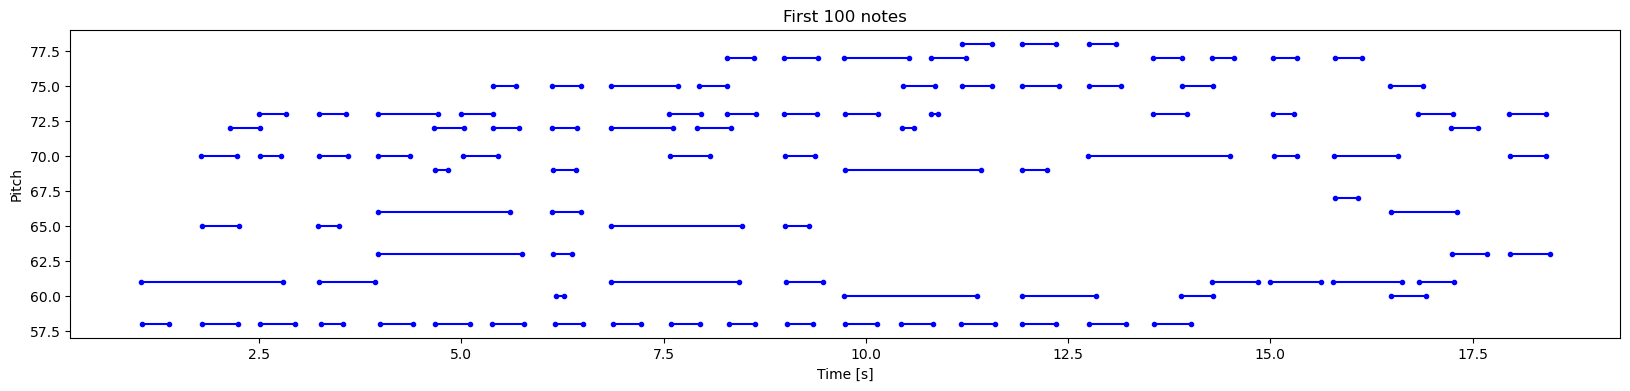

In [16]:
plot_piano_roll(raw_notes, count=100)

In [17]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

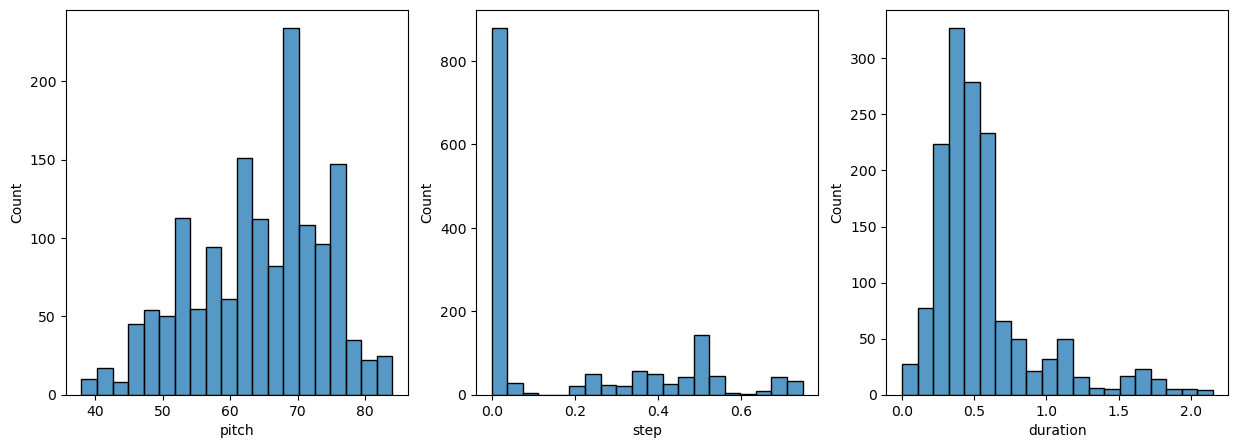

In [18]:
plot_distributions(raw_notes)

In [19]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [20]:
num_files = 5

all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)
  print(len(all_notes))
all_notes = pd.concat(all_notes)

1
2
3
4
5


In [21]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 20532


In [22]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis = 1)
print(train_notes.shape)

(20532, 3)


In [23]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [24]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5703125  0.         0.14713542]
 [0.5859375  0.22916667 0.05208333]
 [0.5703125  0.10807292 0.03645833]
 [0.5859375  0.07161458 0.04947917]
 [0.5703125  0.08723958 0.04817708]
 [0.5859375  0.06510417 0.04427083]
 [0.5703125  0.08333333 0.04296875]
 [0.5859375  0.06640625 0.04166667]
 [0.5703125  0.06901042 0.0390625 ]
 [0.5859375  0.06119792 0.03385417]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=75.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.078125>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.0546875>}


2025-07-17 12:48:27.067024: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [28]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [29]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
losses = model.evaluate(train_ds, return_dict=True)
losses

320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - duration_loss: 0.7394 - loss: 5.7034 - pitch_loss: 4.8460 - step_loss: 0.1180


2025-07-17 12:51:37.517729: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/sam/miniconda3/envs/tf311/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'duration_loss': 0.7468757629394531,
 'loss': 5.686167240142822,
 'pitch_loss': 4.831366539001465,
 'step_loss': 0.10792677849531174}

In [31]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)


In [32]:
model.evaluate(train_ds, return_dict=True)

320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - duration_loss: 0.7394 - loss: 1.0996 - pitch_loss: 0.2423 - step_loss: 0.1180


{'duration_loss': 0.7468757629394531,
 'loss': 1.0963714122772217,
 'pitch_loss': 0.24156825244426727,
 'step_loss': 0.10792677849531174}

In [35]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints_music/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [36]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - duration_loss: 0.0815 - loss: 0.3348 - pitch_loss: 0.2189 - step_loss: 0.0344
Epoch 2/50
  9/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0509 - loss: 0.3926 - pitch_loss: 0.2003 - step_loss: 0.1414

2025-07-17 12:52:52.788365: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/sam/miniconda3/envs/tf311/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0594 - loss: 0.2881 - pitch_loss: 0.2020 - step_loss: 0.0268
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0586 - loss: 0.2808 - pitch_loss: 0.1958 - step_loss: 0.0264
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0578 - loss: 0.2770 - pitch_loss: 0.1930 - step_loss: 0.0262
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0574 - loss: 0.2746 - pitch_loss: 0.1914 - step_loss: 0.0258
Epoch 6/50
  9/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0472 - loss: 0.3734 - pitch_loss: 0.1888 - step_loss: 0.1374

2025-07-17 12:53:10.439028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0579 - loss: 0.2745 - pitch_loss: 0.1912 - step_loss: 0.0253
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0569 - loss: 0.2713 - pitch_loss: 0.1904 - step_loss: 0.0240
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0571 - loss: 0.2699 - pitch_loss: 0.1901 - step_loss: 0.0226
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0563 - loss: 0.2674 - pitch_loss: 0.1897 - step_loss: 0.0214
Epoch 10/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0559 - loss: 0.2661 - pitch_loss: 0.1895 - step_loss: 0.0207
Epoch 11/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0552 - loss: 0.2638 - pitch_loss: 0.1890 - step_loss: 0.0196
Epoch 12/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0561 - loss: 0.2646 - pitch_loss: 0.1888 - step_loss: 0.0196
Epoch 13/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0547

2025-07-17 12:53:45.934491: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0537 - loss: 0.2635 - pitch_loss: 0.1890 - step_loss: 0.0207
Epoch 15/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0535 - loss: 0.2609 - pitch_loss: 0.1882 - step_loss: 0.0192
Epoch 16/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0570 - loss: 0.2727 - pitch_loss: 0.1894 - step_loss: 0.0263
Epoch 17/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0529 - loss: 0.2637 - pitch_loss: 0.1869 - step_loss: 0.0240
Epoch 18/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0517 - loss: 0.2608 - pitch_loss: 0.1864 - step_loss: 0.0227
Epoch 19/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0511 - loss: 0.2587 - pitch_loss: 0.1866 - step_loss: 0.0210
Epoch 20/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0561 - loss: 0.2623 - pitch_loss: 0.1864 - step_loss: 0.0199
Epoch 21/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0

2025-07-17 12:54:56.815185: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0452 - loss: 0.2395 - pitch_loss: 0.1813 - step_loss: 0.0130
Epoch 31/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0431 - loss: 0.2369 - pitch_loss: 0.1803 - step_loss: 0.0136
Epoch 32/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0454 - loss: 0.2382 - pitch_loss: 0.1793 - step_loss: 0.0135
Epoch 33/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0452 - loss: 0.2396 - pitch_loss: 0.1793 - step_loss: 0.0151
Epoch 34/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0392 - loss: 0.2287 - pitch_loss: 0.1778 - step_loss: 0.0117
Epoch 35/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - duration_loss: 0.0420 - loss: 0.2351 - pitch_loss: 0.1784 - step_loss: 0.0148
Epoch 36/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0381 - loss: 0.2306 - pitch_loss: 0.1791 - step_loss: 0.0134
Epoch 37/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - duration_loss: 0.0

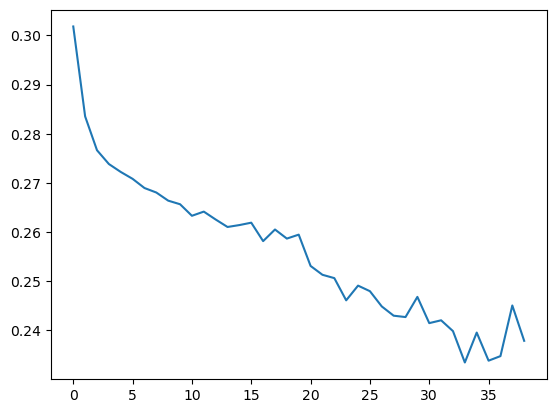

In [37]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [38]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  #temperature changes how random the notes are

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [39]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

In [40]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,64,0.074982,0.624768,0.074982,0.699750
1,100,0.165502,0.272109,0.240484,0.512593
2,100,0.184496,0.353800,0.424980,0.778780
3,97,0.185177,0.356497,0.610157,0.966654
4,100,0.184790,0.355903,0.794947,1.150851
5,98,0.185196,0.356583,0.980143,1.336727
6,93,0.184936,0.356148,1.165079,1.521227
7,100,0.184115,0.354792,1.349194,1.703986
8,84,0.185190,0.356564,1.534384,1.890948
9,100,0.181829,0.351130,1.716212,2.067342


In [41]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)